# GRO620 - Activité procédurale 2

Dans cette activité procédurale, nous allons poser les bases dufiltrage numérique d'images. Vous reconnaîtrez des éléments du filtrage numérique que vous avez vu en S4.

Pour chaque question impliqant de la programmation, commencez par discuter de la procédure à suivre pour résoudre le problème. Nous validerons l'approche en classe avant de se lancer dans l'implémentation.

In [1]:
# Préambule

import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## Si vous utilisez Google Colab, vous devez d'abord monter votre Google Drive
## où se trouve vos données. 
## Commentez les trois lignes suivantes en ajustant le chemin vers votre propre
## dossier :

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/gro620-e21

## Pour retrouver le chemin depuis Jupyter, vous pouvez utiliser ceci :
# !ls /content/gdrive/MyDrive


*J'ai manqué les 17 première mins*

## Caractéristiques de la lumière

### Q1.1

Dans cette image synthétique : 

![](https://upload.wikimedia.org/wikipedia/commons/c/cd/Specular_highlight.jpg)

(source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Specular_highlight.jpg))

**a)** Quelle(s) partie(s) correspondent à l'illumination diffuse et les reflets spéculaires ?

*Complété à Xmins*

*(réponse ici)*

**b)** Quelle information est nécessaire pour déterminer les caractéristiques et emplacements exacts des sources de lumières dans cette image ? Répondez en utilisant des éléments de la *Bidirectional Reflectance Distribution Function* (BRDF).

*(réponse ici)*

## Encodage de l'image

Pour les questions suivantes, vous aurez probablement besoin de lire la documentation de cv2.imread et matplotlib.pyplot.imshow :

[imread](https://pythonexamples.org/python-opencv-read-image-cv2-imread/)

[imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

Le code suivant charge une image et l'affiche en ligne :

*Complété à 36mins*

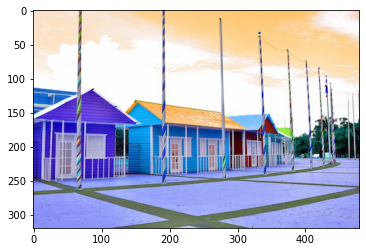

In [8]:
img_color = cv2.imread("images_doc/proc1-q3-color.jpeg")
plt.imshow(img_color)
# Le format d'OpenCv est BGR et non RGB, ce qui fait que les couleurs ont l'air inversées

(source de l'image: [PixaBay, Pexels](https://www.pexels.com/photo/apartment-architecture-block-blue-534124/))

### Q2.1

**a)** Ouvrez directement l'image dans un autre logiciel (le fichier se trouve dans images_doc/proc1-q3-color.jpeg) et comparez le résultat. Que remarquez vous ?

Les couleurs rouge et bleu sont inversées

**b)** Affichez seulement le premier canal de couleurs de l'image. Pensez à analyser la composition de la matrice image que OpenCV vous retourne. Expliquez ensuite ce que vous voyez.

*Complété à 44mins*

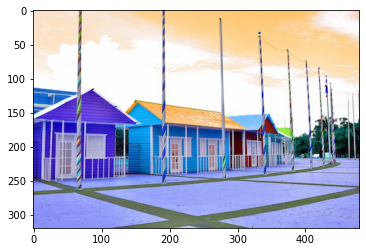

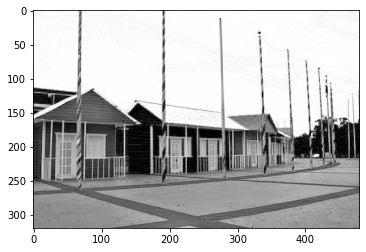

In [27]:
plt.imshow(img_color)              # Image originale
plt.figure()                       # Permet d'afficher plus d'une image dans la même cellule
plt.imshow(img_color[:, :, 0], cmap="gray") # Le paramètre cmap n'a pas d'effet sur une image à plus d'un canal.

**c)** Transformez maintenant l'image pour que les couleurs correspondent à ce que vous voyez en dehors de Jupyter.

*Complété à 55mins*

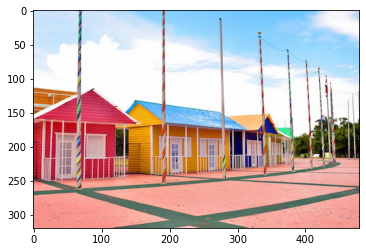

In [32]:
img_correcte = img_color.copy() # Permet de forcer une copie de l'image.
                                # img_correcte = img_color aurait modifié l'originale.
    
img_rgb = cv2.cvtColor(img_correcte, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2RGB is a value from the library
plt.imshow(img_rgb)
# plusieurs autres solutions sont possibles (utilisation split/merge, modification array)

### Q2.2

Soit cette couleur dans l'espace Y'CbCr (on suppose chaque valeur comme étant encodée sur 8 bits) :

$c = [100, 150, 150]$

Trouvez sa valeur équivalente dans l'espace RGB.

*Complété à 1heure 20mins*

In [43]:
c = np.array([100,150,150])

# Méthode lolo
R = 298.082 * c[0]/256 + 408.583 * c[2]/256 - 222.921
G = 298.082 * c[0]/256 - 100.291 * c[1]/256 - 208.120 * c[2]/256 + 135.576
B = 298.082 * c[0]/256 + 516.412 * c[1]/256 - 276.836

print([R, G, B])

# Méthode Jacob
rgb_to_ycbcr = np.array([
    [0.299, 0.587, 0.114],
    [-0.168736, -0.331264, 0.5],
    [0.5, -0.418688, -0.081312]
])

print(np.linalg.inv(rgb_to_ycbcr) @ (c - [0, 128, 128]))

# Méthode Cabana
img_YCC = np.zeros((1, 1, 3), dtype = np.uint8)
img_YCC[:] = c
img_RGB = cv2.cvtColor(img_YCC, cv2.COLOR_YCrCb2RGB)
print(img_RGB[0, 0, :])

[132.92138281250004, 71.3047109375, 142.1874375]
[130.84396413  76.71801966 138.98401039]
[131  77 139]


## Filtrage point à point

### Q3.1

Soit cette image (chargée par OpenCV et affichée par matplotlib): 

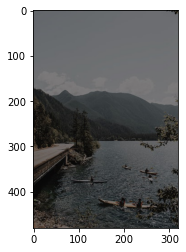

In [45]:
img_q31_org = cv2.imread("images_doc/proc2-q1-dock.jpeg")
img_q31_rgb = cv2.cvtColor(img_q31_org, cv2.COLOR_BGR2RGB) # Équivalent de la question Q3.1.c de l'activité procédurale 1.
plt.imshow(img_q31_rgb)

(Source de l'image originale : [Vlada Karpovich, Pexels](https://www.pexels.com/photo/snow-wood-landscape-mountains-4450090/))

Cette fonction affiche l'histogramme des trois composantes de l'image :

*Voir changement de plage dynamique à 1heure 55mins*

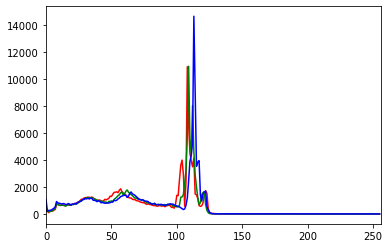

In [46]:
channels = ('r','g','b')
for i, col in enumerate(channels):
    hist = cv2.calcHist([img_q31_rgb], [i], None, [256], [0,256])
    plt.plot(hist,color = col)
    plt.xlim([0,256])

Ajustez la plage dynamique en luminosité de l'image pour qu'elle couvre l'ensemble des valeurs possibles.

*Complété à 1heure 44mins*

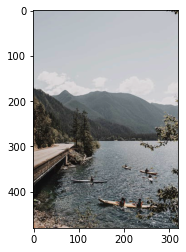

In [55]:
# NOTE: On convertit d'abord en float32 dans la plage [0,1] pour
# simplifier la manipulation des images avec des facteurs non-entiers.
# Matplotlib détecte ceci et affichera l'image correctement.
img_q31_f = np.float32(img_q31_rgb) / 255.0
max_i = img_q31_f.max()
#moy_i = img_q31_f.mean()
img_q31_f/= max_i#moy_i
img_q31_out = img_q31_f.copy() # À remplacer !
plt.imshow(img_q31_out)

## Q3.2

Soit maintenant cette image :

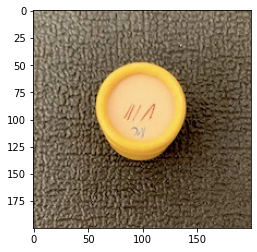

In [56]:
img_q32_org = cv2.imread("images_doc/proc2-q1-object.jpeg")
img_q32_rgb = cv2.cvtColor(img_q32_org, cv2.COLOR_BGR2RGB) # Équivalent de la question Q3.1.c de l'activité procédurale 1.
plt.imshow(img_q32_rgb)

Tentez de mettre en place un algorithme basé sur la luminosité permettant d'éliminer l'arrière-plan de cette image pour qu'il ne reste que l'objet en jaune sur un fond le plus noir possible.

*Complété à 2heures 20mins*

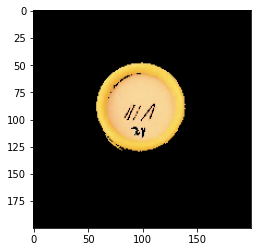

In [72]:
img_q32_filt = img_q32_rgb.copy()
W = img_q32_filt.shape[1] # NOTE: L'ordre des dimensions est Y puis X ("row-major")
H = img_q32_filt.shape[0]

# Solution de Francis
hsv = cv2.cvtColor(img_q32_filt, cv2.COLOR_RGB2HSV)
v_value = hsv[100, 100, 2]
lower = np.array([0, 0, v_value], np.uint8)
upper = np.array([180, 255, 255], np.uint8)
mask = cv2.inRange(hsv, lower, upper)
res = cv2.bitwise_and(img_q32_filt, img_q32_filt, mask = mask)

plt.imshow(res)

## Filtrage linéaire

### Q4.1 

Soit l'image suivante ainsi que sa transformée de Fourier :

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x26304a794c0>)

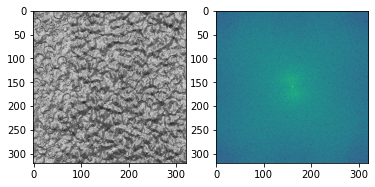

In [73]:
img_q4_org  = cv2.imread("images_doc/proc2-q2-texture.jpeg")
img_q4_mono = np.float32(cv2.cvtColor(img_q4_org, cv2.COLOR_BGR2GRAY)) / 255.0

def get_fft_mag(img):
    img_fft = np.fft.fft2(img)
    img_fft = np.fft.fftshift(img_fft)
    img_fft = 20*np.log(np.abs(img_fft))
    return img_fft
    
img_q4_fft = get_fft_mag(img_q4_mono)

plt.subplot(121),plt.imshow(img_q4_mono, cmap="gray")
plt.subplot(122),plt.imshow(img_q4_fft)

(Source de l'image originale : [Hoang Le, Pexels](https://www.pexels.com/photo/black-and-white-black-and-white-pattern-rough-978462/)).

**a)** Filtrez cette image à l'aide d'une convolution de façon à ce que la valeur de chaque pixel soit la valeur moyenne de ses voisins dans un carré de 15x15.

*Complété à 2heures Xmins*

*p.112 du livre*

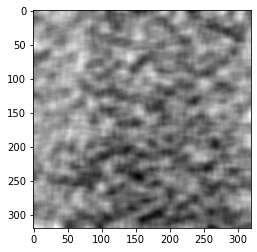

In [83]:
filter_kernel = np.ones((15,15)) * (1/(15**2))
dst = cv2.filter2D(img_q4_mono, -1, filter_kernel)
plt.imshow(dst, cmap="gray")

**b)** Comparez le résultat avec celui de la fonction cv2.GaussianBlur() avec un noyau de convolution de la même taille.

*Complété à 2heures 49mins*

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x263070ef8b0>)

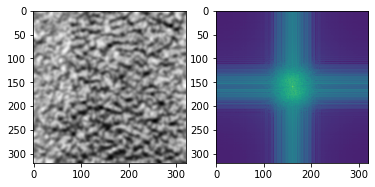

In [92]:
img_q4_blur = img_q4_mono.copy()
gau_blr = cv2.GaussianBlur(img_q4_blur, (15, 15), 0) # le (15, 15) est le noyau de convolution

img_q4_blur_fft = get_fft_mag(gau_blr)

plt.subplot(121),plt.imshow(gau_blr, cmap="gray")
plt.subplot(122),plt.imshow(img_q4_blur_fft)

**c)** Comment expliquez-vous la différence ?

*Complété à 2heures 52mins*

*(réponse ici)*

Vue qu'on associe le même poids à tous les voisins dans la version avec la moyenne (filter2D), on y insère des artefacts

### Q4.2

Utilisez un filtre linéaire pour extraire les contours de l'image fournie en Q3.2.

*Complété au laboratoire et non durant le procédural*

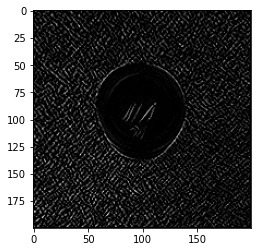

In [94]:
img_q32_contour = img_q32_rgb.copy()

filter_kernel = np.array([[1, 0, -1],
                         [0, 0, 0],
                         [-1, 0, 1]])

img_q32_gray = cv2.cvtColor(img_q32_rgb, cv2.COLOR_BGR2GRAY)

dst = cv2.filter2D(img_q32_gray, -1, filter_kernel)

plt.imshow(dst, cmap="gray")

## Filtrage non-linéaire

### Q5.1

Soit cette image :

*Complété au laboratoire et non durant le procédural*

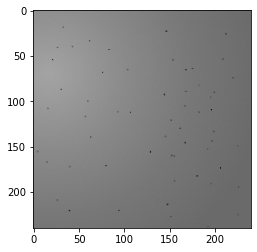

In [77]:
img_q5_org = cv2.imread("images_doc/proc2-q3-sand.png")
img_q5_rgb = cv2.cvtColor(img_q5_org, cv2.COLOR_BGR2RGB)
plt.imshow(img_q5_rgb)

Utilisez un filtre non-linéaire pour retirer les taches noires sur la figure.

In [78]:
img_q5_fixed = img_q5_rgb.copy()